
# Epipolar Geometry
## Computer Vision & Pattern Recognition 2020  ( Professor G. Boracchi)
## Lab. Session 2
------------
### Pietro Verzelli




## Imports and preliminarities

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def draw_line(l, I, options):
    bottomRow = [0, 1, -I.shape[0]]
    topRow = [0, 1, -1]

    intTop = np.cross(l, topRow)
    intTop = intTop / intTop[2];

    intBottom = np.cross(l, bottomRow);
    intBottom = intBottom / intBottom[2];

    plt.plot([intTop[0], intBottom[0]], [intTop[1], intBottom[1]], options)


#### loading the matlab  workspace
from scipy.io import loadmat
cube = loadmat('cube.mat')
img1 = cube['img1']
img2 = cube['img2']

X = cube['X']
Y = cube['Y']
G = cube['G'][:,0]

Data is organized as follows: the first 3 raws are the coordinates of the points of an image, while the last 3 are the coordinates of the mathcing point in the other one.

In [2]:
p = Y[:3][:,G>0]
pP = Y[3:][:,G>0]

Here's a pair of points (note that each point is a column!)

In [3]:
index = 3
print('x ', p[:,index])
print('x_p ',pP[:,index])

x  [189.25695801 370.69085693   1.        ]
x_p  [462.00836182 230.06719971   1.        ]


Let's plot all of them

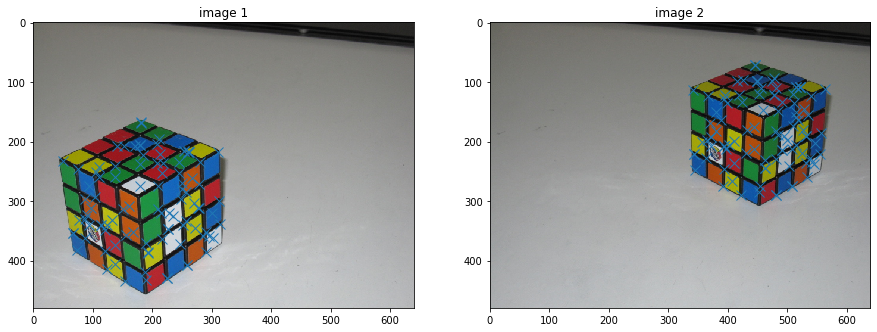

In [4]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,30))

ax1.imshow(img1)
ax1.plot(p[0,:],p[1,:], 'x', ms = 10)
ax1.set_title('image 1')
#ax1.scatter(p[:2], 'x')

ax2.imshow(img2)
ax2.set_title('image 2')
ax2.plot(pP[0,:],pP[1,:],'x', ms = 10)

plt.show()

# The Fundamental Matrix

---------------------

First, we need to create the _preconditioning matrix_ to normalize the points.

$$
T = 
\begin{pmatrix}
\frac{1}{s} & 0 & \frac{t_x}{s}\\
0 & \frac{1}{s} & \frac{t_y}{s}\\
0 & 0   & 1  
\end{pmatrix}
$$

where 

* $t_x$ is the mean of the x-coordinates
* $t_y$ is the mean of the y-coordinates
* $s$ normalize the vector (so is the norm divided the required norm)

In [5]:
def precond_matrix(X):
    #The pts are the columns of X!
    #X[:,i] is the i-th pt 
    
    t_x = np.average(X[0]) #so, these are all the x-coordinates of the pts
    t_y = np.average(X[1]) #and these are the y-coordinates!
    
    s = np.std(X[:2],axis = 0, ddof=0).mean()/ np.sqrt(2)
    
    T = np.zeros((3,3))
    T[0,0]=T[1,1]=1/s
    T[2,2]=1
    T[0,2]=-t_x/s
    T[1,2]=-t_y/s
    
    return T


Now we create the _fundamental matrix_

In [6]:
def fundamental_matrix(X, Y):
    #The pts are the columns of X and Y
    #X[:,i] is the i-th pt 

    n_points = X.shape[1]
    
    #1.compute the preconditioning matrix
    Tx = precond_matrix(X)
    Ty = precond_matrix(Y)
    
    #2.precondition the pts
    Xn = Tx@X
    Yn = Ty@Y
    
    #3.create the design matrix
    A = np.zeros((n_points,9))
    #we do it line by line
    for i in range(n_points):
        x = Xn[:,i]
        y = Yn[:,i]
        A[i,:] = [x[0]*y[0], x[0]*y[1], x[0], x[1]*y[0], x[1]*y[1], x[1],y[0],y[1], 1]
        #another way to do it is simply
        #A[i,:] = np.kron(Xn[:,i], Yn[:,i])
        
    # 4.now the DLT
    U, S, Vt = np.linalg.svd(A)
    V = Vt.T #numpy returns Vt, not V(!!!)
    
    #we reshape the vector to obtain the matrix
    FF = V[:,-1].reshape(3,3).T
    
    #5.enforce the rank to be 2 by truncated svd
    u,s,vt = np.linalg.svd(FF)
    s[-1] = 0  #numpy returns s as a vector 
    #create f just by using the new s
    f = (u*s)@vt
    #invert preconditioning
    F = Ty.T@f@Tx  
    return F
    
    

    

Now we have all the elements to compute the fundamental matrix $F$ for our problem

In [7]:
#Estimate the fundamental matrix
F = fundamental_matrix(p, pP);   



## Epipolar relations
-------------------

We expect the epipolar relation to hold (at least, approximatively).

$$
x_p^{\top} F x \approx 0
$$

and

$$
x^{\top} F^{\top} x_p \approx 0
$$

In [8]:
## verify epipolar relation
indx = 0

Zeros =[]
Zeros_2 = []

for indx in range(97):
    x = p[:, indx]
    xP = pP[:, indx]
    Zeros.append(xP.T @ F @ x)
    Zeros_2.append(x.T @ F.T @ xP)
    
print(np.array(Zeros).mean())
print(np.array(Zeros_2).mean())

0.001395507846697104
0.0013955078466971337


## Epipoles
----------------------------------

To compute the epipoles we simply use the `scipy.linalg.null_space` function.

In [9]:
from scipy.linalg import null_space as null

#find the epipole
e = null(F)
e /= e[2]

Computing the left null space is the same as computing the null space of the transpose.

In [10]:
eP = null(F.T)
eP /= eP[2]

We now compute the epipolar lines for the __second__ image
$$
l_p = F x
$$

In [11]:
lP = F @ p; #pP

And then we plot a bunch of them

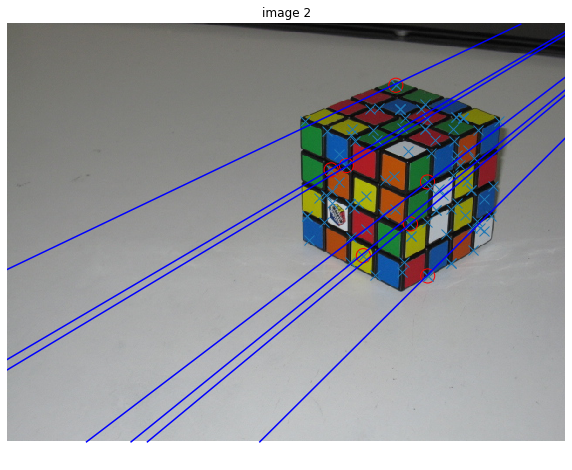

In [12]:
fig, ax1 = plt.subplots(1, figsize = (10,10))

indx_list = [0,1,2,3,4,55, 77]

ax1.imshow(img2)
ax1.plot(pP[0,:],pP[1,:], 'x', ms = 10)
ax1.set_title('image 2')
ax1.set_xlim()
for indx in indx_list:
    plt.scatter(pP[0,indx],pP[1,indx], s= 200
                , facecolors='none', edgecolors='r')
    draw_line(lP[:,indx], img1, 'b')

plt.axis('off')
plt.show()

Finally, we plot the epipoles, which will be the interception of all these lines

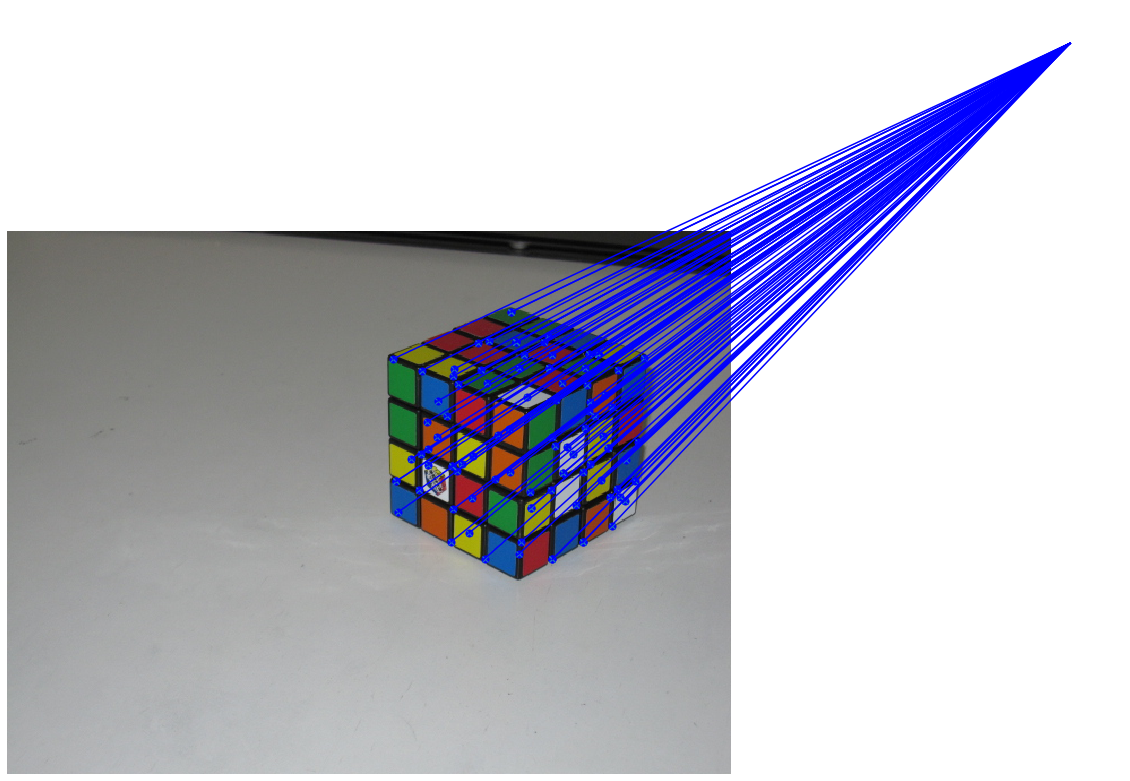

In [13]:
#plot the epipoles

indx_list= np.arange(pP.shape[1])
            
plt.figure(figsize = (20,20))
plt.imshow(img2)
plt.plot(pP[0,:], pP[1,:], 'x')
for indx in indx_list:
    plt.scatter(pP[0,indx], pP[1,indx], s = 50, c='b'  )
    plt.plot([eP[0], pP[0, indx] ], [eP[1], pP[1, indx]], 'b' )   
plt.axis('off')
plt.show()